In [98]:
# Cell [1]
# Import required libraries
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path

# Set visualization parameters
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 10

In [99]:
# Cell [2]
# Download and setup CAMUS dataset
# If using Kaggle API:
# !pip install kaggle
# !kaggle datasets download -d shoybhasan/camus-human-heart-data
# !unzip camus-human-heart-data.zip -d camus_data

# Or manually download and extract to a folder called 'camus_data' or 'database_nifti'
DATA_DIR = "database_nifti"  # Adjust this to your data location

In [100]:
# Cell [3]
# Explore the dataset structure
def explore_dataset(data_dir):
    """Display dataset structure and available patients"""
    if not os.path.exists(data_dir):
        print(f"❌ Directory {data_dir} not found!")
        return None
    
    patients = sorted([d for d in os.listdir(data_dir) 
                      if os.path.isdir(os.path.join(data_dir, d)) 
                      and d.startswith('patient')])
    
    print(f"📊 Found {len(patients)} patients")
    print(f"First 5 patients: {patients[:5]}")
    
    # Check first patient's files
    if patients:
        first_patient = patients[0]
        files = os.listdir(os.path.join(data_dir, first_patient))
        print(f"\n📁 Files for {first_patient}:")
        for f in sorted(files):
            print(f"  - {f}")
    
    return patients

patients = explore_dataset(DATA_DIR)

📊 Found 500 patients
First 5 patients: ['patient0001', 'patient0002', 'patient0003', 'patient0004', 'patient0005']

📁 Files for patient0001:
  - Info_2CH.cfg
  - Info_4CH.cfg
  - MANDATORY_CITATION.md
  - patient0001_2CH_ED.nii.gz
  - patient0001_2CH_ED_gt.nii.gz
  - patient0001_2CH_ES.nii.gz
  - patient0001_2CH_ES_gt.nii.gz
  - patient0001_2CH_half_sequence.nii.gz
  - patient0001_2CH_half_sequence_gt.nii.gz
  - patient0001_4CH_ED.nii.gz
  - patient0001_4CH_ED_gt.nii.gz
  - patient0001_4CH_ES.nii.gz
  - patient0001_4CH_ES_gt.nii.gz
  - patient0001_4CH_half_sequence.nii.gz
  - patient0001_4CH_half_sequence_gt.nii.gz


In [101]:
# Cell [4]
# Helper function to load and visualize a single image
def load_image(pid, view="2CH", phase="ED", data_dir=DATA_DIR):
    """Load a cardiac image"""
    img_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}.nii.gz")
    
    if not os.path.exists(img_path):
        print(f"❌ File not found: {img_path}")
        return None
    
    img = nib.load(img_path).get_fdata()
    return img

def load_mask(pid, view="2CH", phase="ED", data_dir=DATA_DIR):
    """Load ground truth segmentation mask"""
    mask_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}_gt.nii.gz")
    
    if not os.path.exists(mask_path):
        print(f"❌ Mask not found: {mask_path}")
        return None
    
    mask = nib.load(mask_path).get_fdata()
    return mask

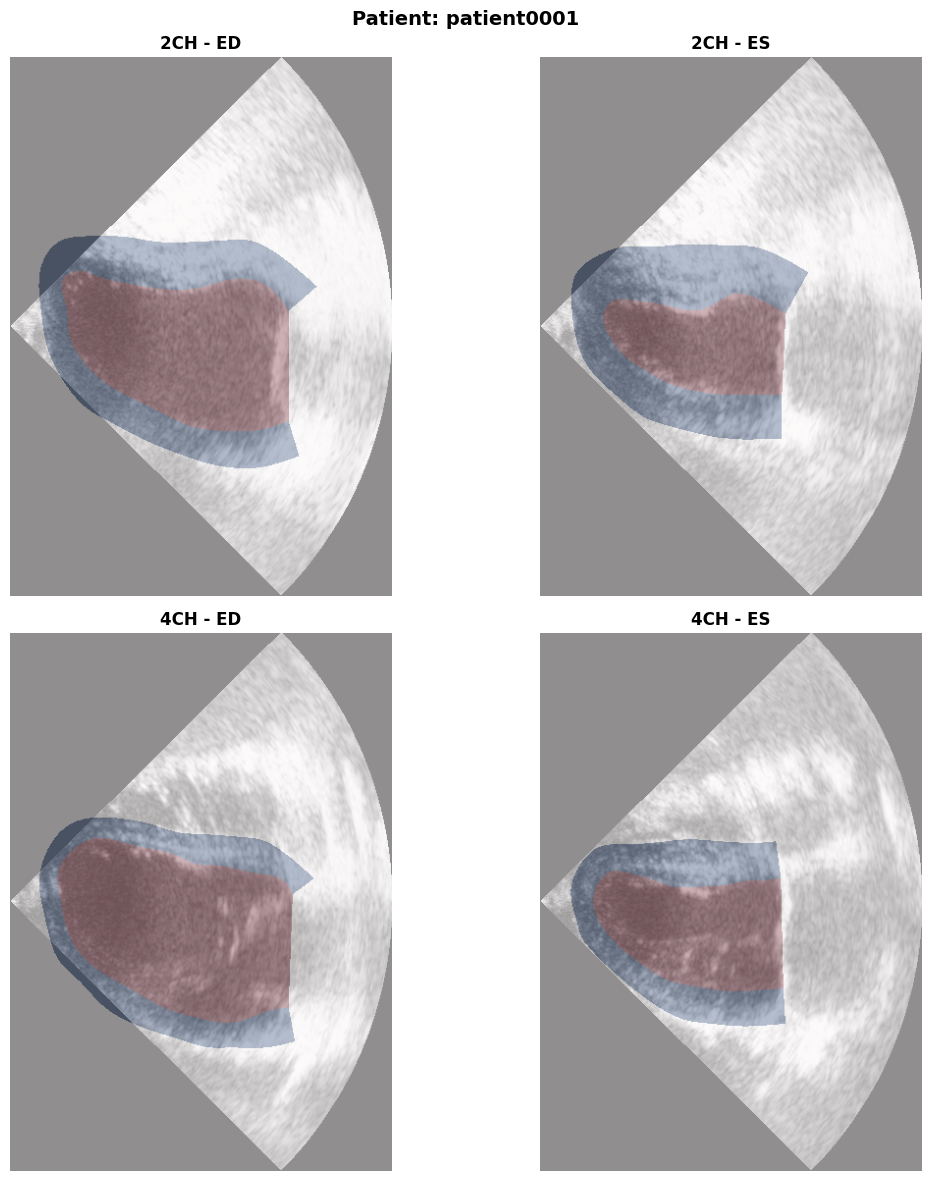

In [102]:
# Cell [5]
# Visualize a single patient's images
def visualize_patient(pid, data_dir=DATA_DIR):
    """Display all views and phases for a patient"""
    views = ["2CH", "4CH"]
    phases = ["ED", "ES"]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for i, view in enumerate(views):
        for j, phase in enumerate(phases):
            ax = axes[i, j]
            
            img = load_image(pid, view, phase, data_dir)
            mask = load_mask(pid, view, phase, data_dir)
            
            if img is not None:
                ax.imshow(img, cmap='gray')
                if mask is not None:
                    # Overlay: LV=1, Myocardium=2, LA=3
                    lv_mask = (mask == 1).astype(float)
                    myo_mask = (mask == 2).astype(float)
                    
                    ax.imshow(lv_mask, alpha=0.4, cmap='Reds')
                    ax.imshow(myo_mask, alpha=0.3, cmap='Blues')
                
                ax.set_title(f"{view} - {phase}", fontsize=12, fontweight='bold')
                ax.axis('off')
    
    plt.suptitle(f"Patient: {pid}", fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Test with a patient
if patients:
    visualize_patient(patients[0])

In [103]:
# Cell [6]
# Function to get LV cavity mask
def get_lv_mask(pid, view="2CH", phase="ED", data_dir=DATA_DIR):
    """
    Returns a boolean LV cavity mask.
    In CAMUS: 1=LV cavity, 2=myocardium, 3=left atrium
    """
    mask = load_mask(pid, view, phase, data_dir)
    if mask is None:
        return None
    return mask == 1

def get_myocardium_mask(pid, view="2CH", phase="ED", data_dir=DATA_DIR):
    """Returns a boolean myocardium mask"""
    mask = load_mask(pid, view, phase, data_dir)
    if mask is None:
        return None
    return mask == 2

In [104]:
# Cell [7]
# Calculate LV area in mm²
def lv_area_mm2(pid, view="2CH", phase="ED", data_dir=DATA_DIR):
    """Calculate LV cavity area in mm²"""
    base = os.path.join(data_dir, pid)
    
    img_path = os.path.join(base, f"{pid}_{view}_{phase}.nii.gz")
    mask_path = os.path.join(base, f"{pid}_{view}_{phase}_gt.nii.gz")
    
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        return None
    
    img_nii = nib.load(img_path)
    mask = nib.load(mask_path).get_fdata()
    
    # Get pixel spacing in mm
    dx, dy = img_nii.header.get_zooms()[:2]
    pixel_area_mm2 = dx * dy
    
    # Count LV pixels (label = 1)
    lv_pixels = (mask == 1).sum()
    
    return lv_pixels * pixel_area_mm2

# Test on a patient
if patients:
    test_pid = patients[0]
    for view in ["2CH", "4CH"]:
        for phase in ["ED", "ES"]:
            area = lv_area_mm2(test_pid, view, phase)
            if area:
                print(f"{test_pid} - {view} {phase}: {area:.1f} mm²")

patient0001 - 2CH ED: 2736.0 mm²
patient0001 - 2CH ES: 1396.6 mm²
patient0001 - 4CH ED: 3167.9 mm²
patient0001 - 4CH ES: 1732.6 mm²


In [105]:
# Cell [8]
# Calculate LV length (long axis)
def lv_length_mm(pid, view="4CH", phase="ED", data_dir=DATA_DIR):
    """Calculate LV long-axis length in mm"""
    base = os.path.join(data_dir, pid)
    
    img_path = os.path.join(base, f"{pid}_{view}_{phase}.nii.gz")
    mask_path = os.path.join(base, f"{pid}_{view}_{phase}_gt.nii.gz")
    
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        return None
    
    img_nii = nib.load(img_path)
    mask = nib.load(mask_path).get_fdata()
    
    dx, dy = img_nii.header.get_zooms()[:2]
    
    # Get LV cavity coordinates
    ys, xs = np.where(mask == 1)
    
    if len(xs) == 0:
        return None
    
    # Approximate long axis as maximum distance between LV pixels
    length_pixels = np.sqrt(
        (xs.max() - xs.min())**2 + 
        (ys.max() - ys.min())**2
    )
    
    # Convert to mm using average pixel spacing
    return length_pixels * np.mean([dx, dy])

# Test
if patients:
    length = lv_length_mm(patients[0], "4CH", "ED")
    if length:
        print(f"LV Length (4CH ED): {length:.1f} mm")

LV Length (4CH ED): 93.5 mm


In [106]:
# Cell [9]
# Calculate LV volume using biplane method (Simpson's method)
def lv_volume_ml(pid, phase="ED", data_dir=DATA_DIR):
    """
    Calculate LV volume in mL using biplane area-length method
    V = (8/3π) × (A_2CH × A_4CH) / L
    """
    A_2ch = lv_area_mm2(pid, "2CH", phase, data_dir)
    A_4ch = lv_area_mm2(pid, "4CH", phase, data_dir)
    L = lv_length_mm(pid, "4CH", phase, data_dir)
    
    if None in [A_2ch, A_4ch, L]:
        return None
    
    # Volume in mm³
    V_mm3 = (8 / (3 * np.pi)) * (A_2ch * A_4ch) / L
    
    # Convert mm³ to mL (1 mL = 1000 mm³)
    return V_mm3 / 1000

# Test on multiple patients
if patients:
    print("📊 LV Volumes for sample patients:\n")
    for pid in patients[:5]:
        edv = lv_volume_ml(pid, "ED")
        esv = lv_volume_ml(pid, "ES")
        
        if edv and esv:
            print(f"{pid}:")
            print(f"  EDV: {edv:.1f} mL")
            print(f"  ESV: {esv:.1f} mL")
            print(f"  SV:  {edv - esv:.1f} mL")
            print(f"  EF:  {((edv - esv) / edv * 100):.1f}%\n")

📊 LV Volumes for sample patients:

patient0001:
  EDV: 78.7 mL
  ESV: 29.2 mL
  SV:  49.5 mL
  EF:  62.9%

patient0002:
  EDV: 95.3 mL
  ESV: 45.4 mL
  SV:  49.9 mL
  EF:  52.3%

patient0003:
  EDV: 81.5 mL
  ESV: 35.5 mL
  SV:  46.1 mL
  EF:  56.5%

patient0004:
  EDV: 76.7 mL
  ESV: 28.2 mL
  SV:  48.4 mL
  EF:  63.2%

patient0005:
  EDV: 55.6 mL
  ESV: 26.6 mL
  SV:  29.0 mL
  EF:  52.1%



In [107]:
# Cell [10]
# Calculate cardiac functional parameters
def calculate_cardiac_metrics(pid, data_dir=DATA_DIR):
    """Calculate comprehensive cardiac metrics"""
    edv = lv_volume_ml(pid, "ED", data_dir)
    esv = lv_volume_ml(pid, "ES", data_dir)
    
    if None in [edv, esv]:
        return None
    
    sv = edv - esv  # Stroke Volume
    ef = (sv / edv) * 100  # Ejection Fraction (%)
    
    return {
        'EDV': edv,
        'ESV': esv,
        'SV': sv,
        'EF': ef}

# Test
if patients:
    metrics = calculate_cardiac_metrics(patients[0])
    if metrics:
        print(f"🫀 Cardiac Metrics for {patients[0]}:")
        print(f"  End-Diastolic Volume (EDV): {metrics['EDV']:.1f} mL")
        print(f"  End-Systolic Volume (ESV):  {metrics['ESV']:.1f} mL")
        print(f"  Stroke Volume (SV):         {metrics['SV']:.1f} mL")
        print(f"  Ejection Fraction (EF):     {metrics['EF']:.1f}%")

🫀 Cardiac Metrics for patient0001:
  End-Diastolic Volume (EDV): 78.7 mL
  End-Systolic Volume (ESV):  29.2 mL
  Stroke Volume (SV):         49.5 mL
  Ejection Fraction (EF):     62.9%


In [108]:
# Cell [11]
# Calculate Cardiac Output
def cardiac_output_L_min(sv_ml, hr_bpm):
    """
    Calculate Cardiac Output in L/min
    CO = Stroke Volume × Heart Rate
    """
    return (sv_ml * hr_bpm) / 1000

# Example with assumed heart rate
if patients:
    metrics = calculate_cardiac_metrics(patients[0])
    if metrics:
        hr = 75  # beats per minute (assumed)
        co = cardiac_output_L_min(metrics['SV'], hr)
        print(f"💓 Cardiac Output @ {hr} bpm: {co:.2f} L/min")

💓 Cardiac Output @ 75 bpm: 3.71 L/min


In [109]:
# Cell [12]
# LVOT area and VTI calculations
def lvot_area_cm2(diameter_cm):
    """Calculate LVOT cross-sectional area"""
    return np.pi * (diameter_cm / 2)**2

def vti_equivalent_cm(sv_ml, lvot_diameter_cm):
    """
    Calculate equivalent VTI (Velocity Time Integral)
    VTI = SV / LVOT_area
    """
    lvot_area = lvot_area_cm2(lvot_diameter_cm)
    sv_cm3 = sv_ml  # 1 mL = 1 cm³
    return sv_cm3 / lvot_area

# Test with range of LVOT diameters
if patients:
    metrics = calculate_cardiac_metrics(patients[0])
    if metrics:
        print(f"📏 VTI estimates for {patients[0]} (SV={metrics['SV']:.1f} mL):\n")
        
        diameters = np.linspace(1.4, 2.4, 11)
        for d in diameters:
            vti = vti_equivalent_cm(metrics['SV'], d)
            print(f"  LVOT diameter = {d:.2f} cm → VTI = {vti:.1f} cm")

📏 VTI estimates for patient0001 (SV=49.5 mL):

  LVOT diameter = 1.40 cm → VTI = 32.2 cm
  LVOT diameter = 1.50 cm → VTI = 28.0 cm
  LVOT diameter = 1.60 cm → VTI = 24.6 cm
  LVOT diameter = 1.70 cm → VTI = 21.8 cm
  LVOT diameter = 1.80 cm → VTI = 19.5 cm
  LVOT diameter = 1.90 cm → VTI = 17.5 cm
  LVOT diameter = 2.00 cm → VTI = 15.8 cm
  LVOT diameter = 2.10 cm → VTI = 14.3 cm
  LVOT diameter = 2.20 cm → VTI = 13.0 cm
  LVOT diameter = 2.30 cm → VTI = 11.9 cm
  LVOT diameter = 2.40 cm → VTI = 10.9 cm


In [110]:
# Cell [13]
# Analyze entire dataset
def analyze_dataset(data_dir=DATA_DIR):
    """Analyze all patients in the dataset"""
    patients = sorted([d for d in os.listdir(data_dir) 
                      if os.path.isdir(os.path.join(data_dir, d)) 
                      and d.startswith('patient')])
    
    results = []
    
    for pid in patients:
        metrics = calculate_cardiac_metrics(pid, data_dir)
        if metrics:
            results.append({
                'patient': pid,
                **metrics
            })
    
    return results

# Run analysis
all_results = analyze_dataset()

print(f"✅ Successfully analyzed {len(all_results)} patients\n")
print("Summary Statistics:")
print("=" * 50)

if all_results:
    edv_values = [r['EDV'] for r in all_results]
    esv_values = [r['ESV'] for r in all_results]
    sv_values = [r['SV'] for r in all_results]
    ef_values = [r['EF'] for r in all_results]
    
    print(f"EDV: {np.mean(edv_values):.1f} ± {np.std(edv_values):.1f} mL")
    print(f"ESV: {np.mean(esv_values):.1f} ± {np.std(esv_values):.1f} mL")
    print(f"SV:  {np.mean(sv_values):.1f} ± {np.std(sv_values):.1f} mL")
    print(f"EF:  {np.mean(ef_values):.1f} ± {np.std(ef_values):.1f} %")

✅ Successfully analyzed 500 patients

Summary Statistics:
EDV: 84.1 ± 32.3 mL
ESV: 42.4 ± 25.5 mL
SV:  41.7 ± 13.9 mL
EF:  51.6 ± 12.3 %


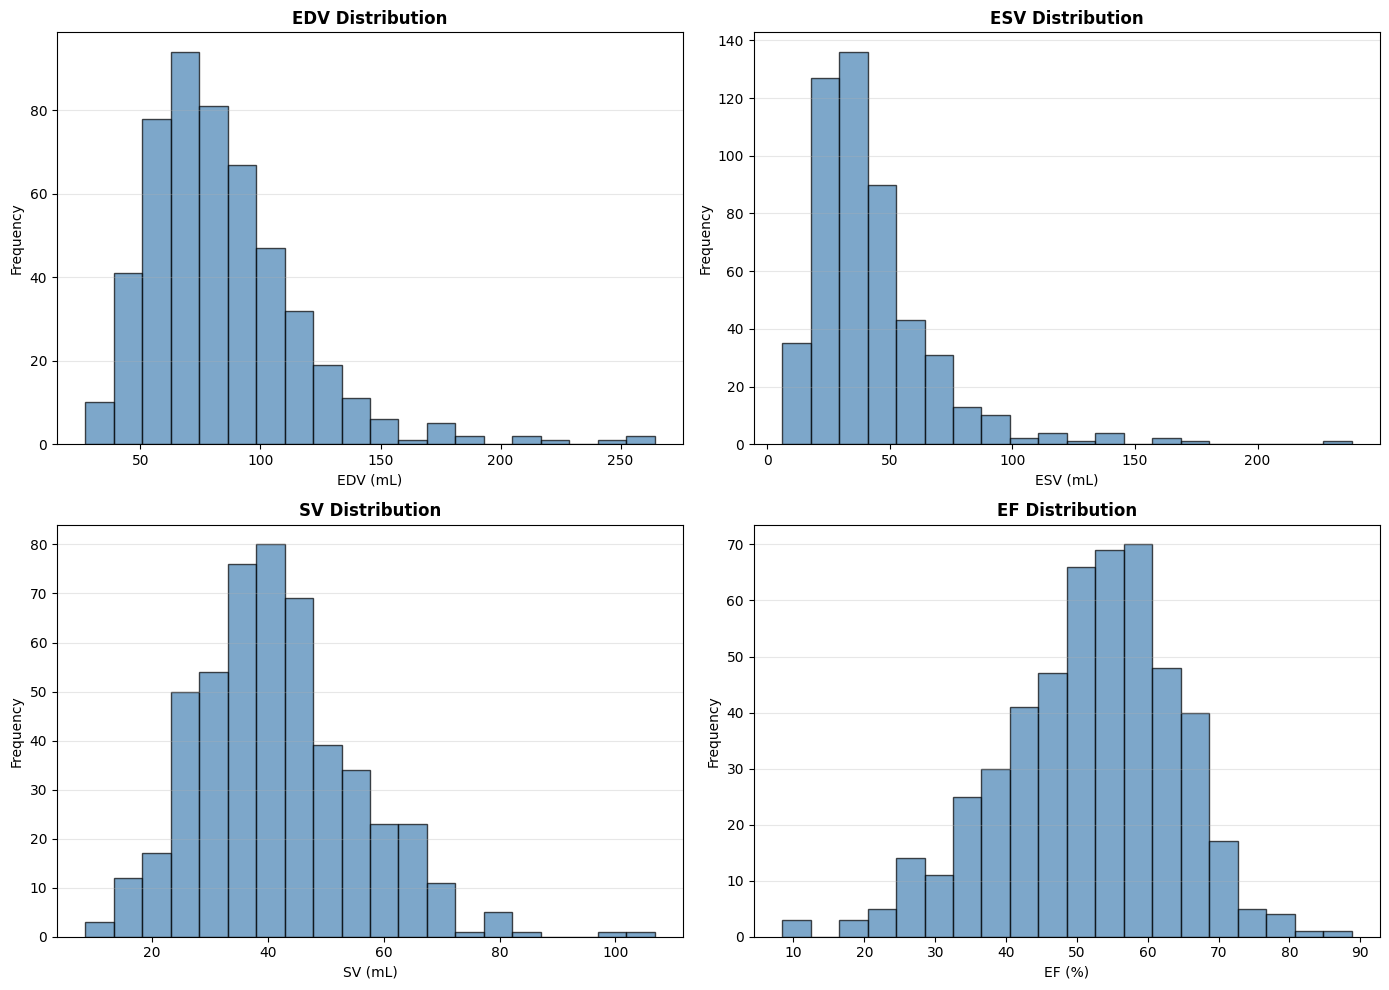

In [117]:
# Cell [14]
# Visualization: Distribution of cardiac metrics
def plot_metrics_distribution(results):
    """Plot distributions of cardiac metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    metrics_data = {
        'EDV': [r['EDV'] for r in results],
        'ESV': [r['ESV'] for r in results],
        'SV': [r['SV'] for r in results],
        'EF': [r['EF'] for r in results]
    }
    
    axes = axes.flatten()
    
    for idx, (metric, values) in enumerate(metrics_data.items()):
        ax = axes[idx]
        ax.hist(values, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_title(f'{metric} Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel(f'{metric} (mL)' if metric != 'EF' else 'EF (%)')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if all_results:
    plot_metrics_distribution(all_results)

In [118]:
# Cell [15]
# Import deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [119]:
# Cell [16]
# U-Net Model Definition
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):  # 4 classes: background, LV, myo, LA
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        self.out = nn.Conv2d(64, out_channels, 1)
        
        self.pool = nn.MaxPool2d(2)
        
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder with skip connections
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        return self.out(d1)

# Test model
model = UNet().to(DEVICE)
print(f"✅ U-Net created with {sum(p.numel() for p in model.parameters()):,} parameters")

✅ U-Net created with 31,042,564 parameters


In [122]:
# Cell [17]
# Custom Dataset for CAMUS with resizing
from torchvision.transforms import functional as F

class CAMUSDataset(Dataset):
    def __init__(self, patient_ids, data_dir, img_size=(256, 256)):
        self.patient_ids = patient_ids
        self.data_dir = data_dir
        self.img_size = img_size
        
        # Create list of all image-mask pairs
        self.samples = []
        for pid in patient_ids:
            for view in ["2CH", "4CH"]:
                for phase in ["ED", "ES"]:
                    img_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}.nii.gz")
                    mask_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}_gt.nii.gz")
                    
                    if os.path.exists(img_path) and os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        
        # Load image and mask
        img = nib.load(img_path).get_fdata().astype(np.float32)
        mask = nib.load(mask_path).get_fdata().astype(np.int64)
        
        # Normalize image to [0, 1]
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        # Convert to tensors
        img = torch.from_numpy(img).unsqueeze(0)  # (1, H, W)
        mask = torch.from_numpy(mask).unsqueeze(0)  # (1, H, W)
        
        # Resize to fixed size
        img = F.resize(img, self.img_size, interpolation=F.InterpolationMode.BILINEAR)
        mask = F.resize(mask, self.img_size, interpolation=F.InterpolationMode.NEAREST)
        
        # Remove extra dimension from mask
        mask = mask.squeeze(0).long()  # (H, W)
        
        return img, mask

# Split dataset
train_patients = patients[:int(0.8 * len(patients))]
val_patients = patients[int(0.8 * len(patients)):]

train_dataset = CAMUSDataset(train_patients, DATA_DIR, img_size=(256, 256))
val_dataset = CAMUSDataset(val_patients, DATA_DIR, img_size=(256, 256))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"📊 Training samples: {len(train_dataset)}")
print(f"📊 Validation samples: {len(val_dataset)}")
print(f"📐 Image size: 256×256")

📊 Training samples: 1600
📊 Validation samples: 400
📐 Image size: 256×256


In [123]:
# Cell [18]
# Training function
def train_segmentation_model(model, train_loader, val_loader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    os.makedirs("checkpoints", exist_ok=True)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "checkpoints/segmentation_model.pt")
            print("✅ Model saved!")

# Train the model
train_segmentation_model(model, train_loader, val_loader, epochs=20)

Epoch 1/20 - Train Loss: 0.3237, Val Loss: 0.1620
✅ Model saved!
Epoch 2/20 - Train Loss: 0.1568, Val Loss: 0.1365
✅ Model saved!
Epoch 3/20 - Train Loss: 0.1340, Val Loss: 0.1345
✅ Model saved!
Epoch 4/20 - Train Loss: 0.1199, Val Loss: 0.1116
✅ Model saved!
Epoch 5/20 - Train Loss: 0.1125, Val Loss: 0.1073
✅ Model saved!
Epoch 6/20 - Train Loss: 0.1036, Val Loss: 0.1003
✅ Model saved!
Epoch 7/20 - Train Loss: 0.0998, Val Loss: 0.1076
Epoch 8/20 - Train Loss: 0.0973, Val Loss: 0.0953
✅ Model saved!
Epoch 9/20 - Train Loss: 0.0920, Val Loss: 0.0948
✅ Model saved!
Epoch 10/20 - Train Loss: 0.0876, Val Loss: 0.0943
✅ Model saved!
Epoch 11/20 - Train Loss: 0.0855, Val Loss: 0.0987
Epoch 12/20 - Train Loss: 0.0854, Val Loss: 0.1074
Epoch 13/20 - Train Loss: 0.0802, Val Loss: 0.0891
✅ Model saved!
Epoch 14/20 - Train Loss: 0.0776, Val Loss: 0.0950
Epoch 15/20 - Train Loss: 0.0724, Val Loss: 0.0924
Epoch 16/20 - Train Loss: 0.0706, Val Loss: 0.0964
Epoch 17/20 - Train Loss: 0.0678, Val Loss:

In [124]:
# Cell [19]
# Load the trained model
SEG_MODEL_PATH = "checkpoints/segmentation_model.pt"

seg_model = UNet().to(DEVICE)
seg_model.load_state_dict(
    torch.load(SEG_MODEL_PATH, map_location=DEVICE, weights_only=True)
)
seg_model.eval()

print("✅ Segmentation model loaded successfully!")

✅ Segmentation model loaded successfully!
